In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from datetime import date
import numpy as np

# import competition_manager as cm
from competition_manager import *

## Generate synthetic teams and games

In [238]:
def calculate_team_strength(team_players):
    # Base strength sum
    strength = player_strengths[team_players].sum()
    print(f"Base strength of team {team_players}: {strength:.4f}")
    
    # Compute favorite player boost (fixed)
    for i, pair in enumerate(friend_pairs):
        if all(player in team_players for player in pair):
            boost = friend_pairs_boost[i]
            strength += boost
            print(f"Favorite pair boost applied for players {pair}: +{boost:.4f}, total strength now {strength:.4f}")
    for i, triplet in enumerate(friend_triplets):
        if all(player in team_players for player in triplet):
            boost = friend_triplets_boost[i]
            strength += boost
            print(f"Favorite triplet boost applied for players {triplet}: +{boost:.4f}, total strength now {strength:.4f}")
    
    # Compute skills boost correlated with players' average strength
    for i, pair in enumerate(skilled_pairs):
        if all(player in team_players for player in pair):
            avg_strength = player_strengths[list(pair)].mean()
            boost = skilled_pairs_boost[i] * avg_strength
            strength += boost
            print(f"Skills pair boost for players {pair}: avg strength {avg_strength:.4f} * boost factor {skilled_pairs_boost[i]:.4f} = +{boost:.4f}, total strength now {strength:.4f}")
    
    for i, triplet in enumerate(skilled_triplets):
        if all(player in team_players for player in triplet):
            avg_strength = player_strengths[list(triplet)].mean()
            boost = skilled_triplets_boost[i] * avg_strength
            strength += boost
            print(f"Skills triplet boost for players {triplet}: avg strength {avg_strength:.4f} * boost factor {skilled_triplets_boost[i]:.4f} = +{boost:.4f}, total strength now {strength:.4f}")
    
    return strength

In [239]:
np.random.seed(42)  # for reproducibility

NUM_PLAYERS = 30  # player 0 is ignore/masked and 1 is added to account for this
MIN_TEAM_SIZE = 5
MAX_TEAM_SIZE = 9
NUM_GAMES = 50

# 1. Generate players' strengths: single float number [0, 1]
player_strengths = np.random.rand(NUM_PLAYERS + 1) # player 0 is ignore/masked 

# 2. Generate favorite player pairs and triplets (friends)
num_friend_pairs = 10
num_friend_triplets = 5

# Randomly select unique pairs
friend_pairs = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS +1), size=2, replace=False)) for _ in range(num_friend_pairs)]
friend_pairs_boost = np.random.uniform(0.05, 0.15, size=num_friend_pairs)  # small boost

# Randomly select unique triplets
friend_triplets = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS +1), size=3, replace=False)) for _ in range(num_friend_triplets)]
friend_triplets_boost = np.random.uniform(0.1, 0.25, size=num_friend_triplets)  # larger boost

# 3. Generate skilled pairs and triplets (high skill synergy)
num_skilled_pairs = 8
num_skilled_triplets = 4

skilled_pairs = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS + 1), size=2, replace=False)) for _ in range(num_skilled_pairs)]
skilled_pairs_boost = np.random.uniform(0.1, 0.2, size=num_skilled_pairs)  # moderate boost

skilled_triplets = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS + 1), size=3, replace=False)) for _ in range(num_skilled_triplets)]
skilled_triplets_boost = np.random.uniform(0.15, 0.3, size=num_skilled_triplets)  # strong boost

# 2. Prepare arrays to hold the dataset
teamA_data = np.zeros((NUM_GAMES, MAX_TEAM_SIZE), dtype=int)
teamB_data = np.zeros((NUM_GAMES, MAX_TEAM_SIZE), dtype=int)
labels = np.zeros(NUM_GAMES)

def drop_zeroes_for_sum(players_strengths):
    return players_strengths[players_strengths !=0]

for game_i in range(NUM_GAMES):
    # Random sizes for both teams in [MIN_TEAM_SIZE, MAX_TEAM_SIZE]

    team_size = np.random.randint(MIN_TEAM_SIZE, MAX_TEAM_SIZE + 1)

    # Randomly sample distinct players for each team (sampling with replacement allowed for simplicity)
    # To avoid overlap if needed: sample without replacement from full 32 for both teams combined,
    # here assuming players can appear on both teams (as per original conversation)
    # teamA_players = np.random.choice(NUM_PLAYERS, size=teamA_size, replace=False)
    # teamB_players = np.random.choice(NUM_PLAYERS, size=teamB_size, replace=False)
    
    # Shuffle all players and split into two disjoint teams
    all_players = np.random.permutation(NUM_PLAYERS)
    teamA_players = all_players[:team_size]
    teamB_players = all_players[team_size:2*team_size]
    
    print(f"Game # {game_i} evaluation: ")
    # Compute team strengths as sum of player strengths
    teamA_strength = calculate_team_strength(teamA_players)
    teamB_strength = calculate_team_strength(teamB_players)
    print(f"=" * 50)
    
    # print(f"Team A strengths {player_strengths[teamA_players]} Total: {teamA_strength}")

    # Calculate match outcome: 1 if Team A wins, 0 if Team B wins
    # Add small noise to simulate unpredictability
    outcome = teamA_strength - teamB_strength + np.random.normal(scale=0.1)
    labels[game_i] = outcome

    # Pad teams to max size using zeros (which corresponds to masked player)
    teamA_data[game_i, :team_size] = teamA_players
    teamB_data[game_i, :team_size] = teamB_players

print("player_strengths shape:", player_strengths.shape)
print("teamA_data shape:", teamA_data.shape)
print("teamB_data shape:", teamB_data.shape)
print("labels shape:", labels.shape)

# Example print first 3 games
for i in range(3):
    print(f"Game {i+1}:")
    teamA_pls = teamA_data[i]
    print(" Team A players: ", teamA_pls)
    print(" Team A palyers' stregths: ", player_strengths[teamA_pls])

    teamB_pls = teamB_data[i]
    print(" Team B players: ", teamB_pls)
    print(f"Team B strengths {drop_zeroes_for_sum(player_strengths[teamB_pls]).sum()}")
    print(" Team B palyers' stregths: ", player_strengths[teamB_pls])
    print(" Label (Team A wins=1):", labels[i])


Game # 0 evaluation: 
Base strength of team [ 3  7 18 23 22  2 25  6 24]: 4.5866
Favorite triplet boost applied for players (np.int64(24), np.int64(2), np.int64(18)): +0.1755, total strength now 4.7621
Base strength of team [29 14 15 26 10 12 28 19 16]: 2.6523
Favorite pair boost applied for players (np.int64(15), np.int64(14)): +0.0544, total strength now 2.7066
Skills pair boost for players (np.int64(10), np.int64(12)): avg strength 0.4265 * boost factor 0.1377 = +0.0587, total strength now 2.7653
Game # 1 evaluation: 
Base strength of team [15  8 20  3  4  0  7 16  5]: 3.8520
Favorite pair boost applied for players (np.int64(16), np.int64(4)): +0.1072, total strength now 3.9592
Favorite pair boost applied for players (np.int64(16), np.int64(8)): +0.1269, total strength now 4.0861
Base strength of team [ 9 25 11 10 29 17 27  2  6]: 4.3593
Favorite pair boost applied for players (np.int64(9), np.int64(10)): +0.1248, total strength now 4.4840
Game # 2 evaluation: 
Base strength of team

## Prepare real players data

In [76]:
team_members = ["Andrey Spiridonov", "Andrey Trubicin", "Andrey Larionov", "Veselin", "Fedor", "Andrey Selifonov",
                "Dmitro Ilchenko", "Sergii Kolbasin", "Vlad", "Pavel Karacharov", "Sanya", "Roman", "Ivan", "Denys", "Vitalii Zhebrakovksy",
                "Oleksandr", "Loginov Dmitrii", "Artem Bykov", "Kirill", "Bondarev Yurii", "Gundars Mednis", "Alexandr Mikhailov",
                "Pedro Ispanec", "Dimon Sirnik Lozuk", "Sergey Konovalov", "Vladimir Chavskiy", "Alex Akimov", "Andrey", "Sanya DrugIlchenko", 
                "Vitalik goalkeeper", "Dimon Melkii"]


In [77]:
team_members_with_ids = {idx + 1: tm for idx, tm in enumerate(team_members)}
team_members_with_ids

{1: 'Andrey Spiridonov',
 2: 'Andrey Trubicin',
 3: 'Andrey Larionov',
 4: 'Veselin',
 5: 'Fedor',
 6: 'Andrey Selifonov',
 7: 'Dmitro Ilchenko',
 8: 'Sergii Kolbasin',
 9: 'Vlad',
 10: 'Pavel Karacharov',
 11: 'Sanya',
 12: 'Roman',
 13: 'Ivan',
 14: 'Denys',
 15: 'Vitalii Zhebrakovksy',
 16: 'Oleksandr',
 17: 'Loginov Dmitrii',
 18: 'Artem Bykov',
 19: 'Kirill',
 20: 'Bondarev Yurii',
 21: 'Gundars Mednis',
 22: 'Alexandr Mikhailov',
 23: 'Pedro Ispanec',
 24: 'Dimon Sirnik Lozuk',
 25: 'Sergey Konovalov',
 26: 'Vladimir Chavskiy',
 27: 'Alex Akimov',
 28: 'Andrey',
 29: 'Sanya DrugIlchenko',
 30: 'Vitalik goalkeeper',
 31: 'Dimon Melkii'}

In [240]:

def name_to_var(name):
    """Convert a full name string into a valid Python variable name."""
    # Lowercase, replace spaces with underscores, remove non-alphanumeric/underscore characters
    import re
    var = name.lower()
    var = var.replace(' ', '_')
    var = re.sub(r'[^0-9a-z_]', '', var)
    return var

# Define variables dynamically in globals()
for idx, name in team_members_with_ids.items():
    var_name = name_to_var(name)
    globals()[var_name] = idx

In [79]:
historical_cometitions = [
    Competition([loginov_dmitrii, andrey_spiridonov, veselin, alexandr_mikhailov, ivan],
     [kirill, andrey_trubicin, oleksandr, fedor, denys], 11, date(2025, 7, 13 )),

    Competition([roman, oleksandr, andrey_trubicin, denys, andrey_selifonov, veselin],
     [alex_akimov, loginov_dmitrii, andrey_larionov, vitalik_goalkeeper, artem_bykov, andrey_spiridonov], 1, date(2025, 7, 6 )),

    Competition([andrey_selifonov, roman, loginov_dmitrii, andrey_trubicin, kirill, vitalik_goalkeeper],
     [oleksandr, andrey_larionov, sergii_kolbasin, andrey_spiridonov, pavel_karacharov, vlad], 2, date(2025, 6, 22 )),

    Competition([ivan, artem_bykov, andrey_larionov, oleksandr, gundars_mednis, veselin, vitalii_zhebrakovksy, andrey_spiridonov],
     [andrey_trubicin, loginov_dmitrii, dimon_sirnik_lozuk, kirill, alex_akimov, dimon_melkii, roman, sergii_kolbasin], 3, date(2025, 6, 14 )),

    Competition([andrey_trubicin, loginov_dmitrii, roman, sergii_kolbasin, gundars_mednis],
     [andrey_spiridonov, oleksandr, vlad, alex_akimov, vitalii_zhebrakovksy], 3, date(2025, 6, 9 )),

    Competition([ivan, bondarev_yurii, loginov_dmitrii, andrey_larionov, fedor, andrey_spiridonov, roman, dimon_sirnik_lozuk],
     [oleksandr, dimon_melkii, andrey_selifonov, artem_bykov, andrey_trubicin, gundars_mednis, pedro_ispanec, veselin], 3, date(2025, 6, 8 )),

    Competition([andrey_larionov, vitalii_zhebrakovksy, roman, andrey_spiridonov, loginov_dmitrii, sergii_kolbasin],
     [oleksandr, veselin, andrey_selifonov, bondarev_yurii, alex_akimov, andrey_trubicin], 1, date(2025, 5, 25 )),

    Competition([oleksandr, fedor, andrey_spiridonov, loginov_dmitrii, vitalii_zhebrakovksy, pavel_karacharov],
     [pedro_ispanec, andrey, andrey_trubicin, artem_bykov, roman, kirill], 1, date(2025, 5, 4 )), # 14:13

    Competition([loginov_dmitrii, alex_akimov, andrey_larionov, oleksandr, veselin, andrey, andrey_trubicin],
     [bondarev_yurii, artem_bykov, ivan, gundars_mednis, andrey_selifonov, roman, andrey_spiridonov], -2, date(2025, 4, 12 )), # 9:11

    Competition([andrey_larionov, gundars_mednis, andrey_spiridonov, loginov_dmitrii, andrey_selifonov],
     [oleksandr, vitalii_zhebrakovksy, andrey_trubicin, roman, denys], -3, date(2025, 4, 6 )), # 13:16

    
    
    Competition([andrey_trubicin, fedor, gundars_mednis, pedro_ispanec, loginov_dmitrii],
     [ivan, roman, alexandr_mikhailov, andrey_spiridonov, andrey_selifonov], -4, date(2025, 3, 29 )),

    Competition([loginov_dmitrii, dimon_sirnik_lozuk, roman, sanya, andrey_larionov, sergii_kolbasin, roman, denys],
     [veselin, andrey_spiridonov, andrey_trubicin, fedor, pedro_ispanec, artem_bykov, andrey, vlad], -4, date( 2025, 3, 22)),

    Competition([roman, andrey_spiridonov, andrey_trubicin, ivan, pedro_ispanec, denys, artem_bykov],
     [bondarev_yurii, fedor, kirill, oleksandr, andrey_larionov, veselin, loginov_dmitrii], 0, date(2025, 3, 9)),

    Competition([andrey_larionov, oleksandr, andrey_trubicin, veselin, loginov_dmitrii, kirill, roman, pedro_ispanec, pavel_karacharov],
     [ivan, dmitro_ilchenko, andrey_spiridonov, fedor, artem_bykov, sanya, sanya_drugilchenko, andrey_selifonov, alexandr_mikhailov], -1, date(2025, 3, 2)),

    Competition([oleksandr, vlad, andrey_spiridonov, artem_bykov, andrey_larionov, andrey_trubicin, roman, bondarev_yurii],
     [ivan, fedor, loginov_dmitrii, denys, dmitro_ilchenko, andrey_selifonov, sergii_kolbasin, pedro_ispanec], 1, date(2025, 2, 8)),

    Competition([roman, andrey_trubicin, ivan, andrey_spiridonov, veselin, vlad, sergii_kolbasin, andrey_selifonov],
     [denys, oleksandr, dmitro_ilchenko, fedor, artem_bykov, andrey_larionov, loginov_dmitrii, sanya], 0, date(2025, 2, 1)),

    Competition([loginov_dmitrii, alexandr_mikhailov, bondarev_yurii, pavel_karacharov, fedor, dmitro_ilchenko],
     [oleksandr, andrey_trubicin, andrey, andrey_larionov, artem_bykov, vitalii_zhebrakovksy], 0, date(2025, 1, 26)),

    
    Competition([bondarev_yurii, dmitro_ilchenko, roman, andrey_trubicin, andrey_spiridonov, vlad, pavel_karacharov, artem_bykov],
     [loginov_dmitrii, veselin, ivan, oleksandr, vitalii_zhebrakovksy, sergii_kolbasin, denys, andrey_larionov], 0, date(2025, 1, 18)),  # Black legs matter

    Competition([vitalii_zhebrakovksy, loginov_dmitrii, ivan, andrey_spiridonov, andrey_larionov, andrey_trubicin, veselin],
     [sanya, roman, denys, andrey_spiridonov, andrey_selifonov, oleksandr, alex_akimov], 0, date(2024, 12, 29)),
]

In [80]:
np.random.seed(42)  # for reproducibility

NUM_PLAYERS = len(team_members_with_ids)
MIN_TEAM_SIZE = 5
MAX_TEAM_SIZE = 9
NUM_GAMES = len(historical_cometitions)

teamA_data = np.zeros((NUM_GAMES, MAX_TEAM_SIZE), dtype=int)
teamB_data = np.zeros((NUM_GAMES, MAX_TEAM_SIZE), dtype=int)
labels = np.zeros(NUM_GAMES)

print(f"Shape of teamA_data: {teamA_data.shape}")

for comp_i, competition in enumerate(historical_cometitions):

    teamA_players = competition.team_a
    teamB_players = competition.team_b
    assert len(teamA_players) == len(teamB_players), f"Teams are supposed to be of equal size, Team A:{len(teamA_players)} Team B: {len(teamB_players)}"
    team_size = len(teamA_players)

    labels[comp_i] = competition.score_diff

    # print(teamA_players)
    # print(teamB_players)
    # Pad teams to max size using zeros (which corresponds to masked player)
    teamA_data[comp_i, :team_size] = teamA_players
    teamB_data[comp_i, :team_size] = teamB_players

print("teamA_data shape:", teamA_data.shape)
print("teamB_data shape:", teamB_data.shape)
print("labels shape:", labels.shape)

Shape of teamA_data: (19, 9)
teamA_data shape: (19, 9)
teamB_data shape: (19, 9)
labels shape: (19,)


## Version of the model for real data

In [136]:
teamB_data.shape

(10000, 9)

In [82]:
# Constants (adjust as needed)
NUM_PLAYERS = len(team_members_with_ids)
PLAYER_EMB_DIM = 32
NUM_CLASSES = 1  # Binary: win/loss

# Inputs: variable-length teams
teamA_input = Input(shape=(None,), dtype='int32', name='teamA')  # variable-length
teamB_input = Input(shape=(None,), dtype='int32', name='teamB')  # variable-length

# Embedding layer with mask support
player_embedding = layers.Embedding(
    input_dim=NUM_PLAYERS + 1,  # includes 0 for mask
    output_dim=PLAYER_EMB_DIM,
    mask_zero=True,  # Important: enables automatic masking for padding (0 as pad token)
    embeddings_regularizer=tf.keras.regularizers.l2(1e-4),
    name='player_embedding'
)

# Embed team players
teamA_embeds = player_embedding(teamA_input)  # shape: (batch, teamA_len, emb_dim)
teamB_embeds = player_embedding(teamB_input)

# Self-attention block (respects masks automatically if using Functional API)
def self_attention_block(x, name_prefix=''):
    attn_output = layers.MultiHeadAttention(
        num_heads=4,
        key_dim=PLAYER_EMB_DIM,
        dropout=0.1,
        name=f'{name_prefix}_attn'
    )(x, x)
    x = layers.Add(name=f'{name_prefix}_residual')([x, attn_output])
    x = layers.LayerNormalization(name=f'{name_prefix}_norm')(x)
    return x

# Apply attention
teamA_attn = self_attention_block(teamA_embeds, 'teamA')
teamB_attn = self_attention_block(teamB_embeds, 'teamB')

# Global average pooling over valid (non-padded) tokens
# TF handles masking automatically in GlobalAveragePooling1D if mask_zero=True
teamA_vector = layers.GlobalAveragePooling1D(name='teamA_avgpool')(teamA_attn)
teamB_vector = layers.GlobalAveragePooling1D(name='teamB_avgpool')(teamB_attn)

# Matchup modeling (difference vector)
matchup_vector = layers.Subtract(name='matchup_diff')([teamA_vector, teamB_vector])

# Concatenate summary representation
match_input = layers.Concatenate(name='match_features')([teamA_vector, teamB_vector, matchup_vector])

# Feedforward classification head
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(match_input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
# output = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)
output = layers.Dense(1, activation='linear', name='regression_output')(x)

# Final model
model = Model(inputs=[teamA_input, teamB_input], outputs=output)
model.compile(optimizer='adam', 
              loss='mean_squared_error',   # or 'mean_absolute_error'
                metrics=['mean_absolute_error']
             )

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ teamA (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, None, 32)  │      1,024 │ teamA[0][0],      │
│ (Embedding)         │                   │            │ teamB[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_14        │ (None, None)      │          0 │ teamA[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_15        │ (None, None)      │          0 │ teamB[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_attn          │ (None, None, 32)  │     16,800 │ player_embedding… │
│ (MultiHeadAttentio… │                   │            │ player_embedding… │
│                     │                   │            │ not_equal_14[0][… │
│                     │                   │            │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_attn          │ (None, None, 32)  │     16,800 │ player_embedding… │
│ (MultiHeadAttentio… │                   │            │ player_embedding… │
│                     │                   │            │ not_equal_15[0][… │
│                     │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_residual      │ (None, None, 32)  │          0 │ player_embedding… │
│ (Add)               │                   │            │ teamA_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_residual      │ (None, None, 32)  │          0 │ player_embedding… │
│ (Add)               │                   │            │ teamB_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_norm          │ (None, None, 32)  │         64 │ teamA_residual[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or_14       │ (None, None)      │          0 │ not_equal_14[0][… │
│ (LogicalOr)         │                   │            │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_norm          │ (None, None, 32)  │         64 │ teamB_residual[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or_15       │ (None, None)      │          0 │ not_equal_15[0][… │
│ (LogicalOr)         │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_avgpool       │ (None, 32)        │          0 │ teamA_norm[0][0], │
│ (GlobalAveragePool… │                   │            │ logical_or_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_avgpool       │ (None, 32)        │          0 │ teamB_norm[0][0], │
│ (GlobalAveragePool… │                   │            │ logical_or_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ matchup_diff        │ (None, 32)        │          0 │ teamA_avgpool[0]… │
│ (Subtract)          │                   │            │ teamB_avgpool[0]

 Total params: 43,073 (168.25 KB)

 Trainable params: 43,073 (168.25 KB)

 Non-trainable params: 0 (0.00 B)

## Version of the model for generated data

In [241]:
if True:
    # Constants (adjust as needed)
    PLAYER_EMB_DIM = 32
    # NUM_CLASSES = 1  # Binary: win/loss
    
    # Inputs: variable-length teams
    teamA_input = Input(shape=(None,), dtype='int32', name='teamA')  # variable-length
    teamB_input = Input(shape=(None,), dtype='int32', name='teamB')  # variable-length
    
    # Embedding layer with mask support
    player_embedding = layers.Embedding(
        input_dim=NUM_PLAYERS + 1,
        output_dim=PLAYER_EMB_DIM,
        mask_zero=True,  # Important: enables automatic masking for padding (0 as pad token)
        embeddings_regularizer=tf.keras.regularizers.l2(1e-4),
        name='player_embedding'
    )
    
    # Embed team players
    teamA_embeds = player_embedding(teamA_input)  # shape: (batch, teamA_len, emb_dim)
    teamB_embeds = player_embedding(teamB_input)
    
    # Self-attention block (respects masks automatically if using Functional API)
    def self_attention_block(x, name_prefix=''):
        attn_output = layers.MultiHeadAttention(
            num_heads=4,
            key_dim=PLAYER_EMB_DIM,
            dropout=0.1,
            name=f'{name_prefix}_attn'
        )(x, x)
        x = layers.Add(name=f'{name_prefix}_residual')([x, attn_output])
        x = layers.LayerNormalization(name=f'{name_prefix}_norm')(x)
        return x
    
    # Apply attention
    teamA_attn = self_attention_block(teamA_embeds, 'teamA')
    teamB_attn = self_attention_block(teamB_embeds, 'teamB')
    
    # Global average pooling over valid (non-padded) tokens
    # TF handles masking automatically in GlobalAveragePooling1D if mask_zero=True
    teamA_vector = layers.GlobalAveragePooling1D(name='teamA_avgpool')(teamA_attn)
    teamB_vector = layers.GlobalAveragePooling1D(name='teamB_avgpool')(teamB_attn)
    
    # Matchup modeling (difference vector)
    matchup_vector = layers.Subtract(name='matchup_diff')([teamA_vector, teamB_vector])
    
    # Concatenate summary representation
    match_input = layers.Concatenate(name='match_features')([teamA_vector, teamB_vector, matchup_vector])
    
    # Feedforward classification head
    x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(match_input)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='linear', name='regression_output')(x)

    # Final model
    model = Model(inputs=[teamA_input, teamB_input], outputs=output)
    model.compile(optimizer='adam', 
                  loss='mean_squared_error',   # or 'mean_absolute_error'
                    metrics=['mean_absolute_error']
                 )

    model.summary()


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ teamA (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, None, 32)  │        992 │ teamA[0][0],      │
│ (Embedding)         │                   │            │ teamB[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_48        │ (None, None)      │          0 │ teamA[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_49        │ (None, None)      │          0 │ teamB[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_attn          │ (None, None, 32)  │     16,800 │ player_embedding… │
│ (MultiHeadAttentio… │                   │            │ player_embedding… │
│                     │                   │            │ not_equal_48[0][… │
│                     │                   │            │ not_equal_48[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_attn          │ (None, None, 32)  │     16,800 │ player_embedding… │
│ (MultiHeadAttentio… │                   │            │ player_embedding… │
│                     │                   │            │ not_equal_49[0][… │
│                     │                   │            │ not_equal_49[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_residual      │ (None, None, 32)  │          0 │ player_embedding… │
│ (Add)               │                   │            │ teamA_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_residual      │ (None, None, 32)  │          0 │ player_embedding… │
│ (Add)               │                   │            │ teamB_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_norm          │ (None, None, 32)  │         64 │ teamA_residual[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or_48       │ (None, None)      │          0 │ not_equal_48[0][… │
│ (LogicalOr)         │                   │            │ not_equal_48[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_norm          │ (None, None, 32)  │         64 │ teamB_residual[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or_49       │ (None, None)      │          0 │ not_equal_49[0][… │
│ (LogicalOr)         │                   │            │ not_equal_49[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_avgpool       │ (None, 32)        │          0 │ teamA_norm[0][0], │
│ (GlobalAveragePool… │                   │            │ logical_or_48[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_avgpool       │ (None, 32)        │          0 │ teamB_norm[0][0], │
│ (GlobalAveragePool… │                   │            │ logical_or_49[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ matchup_diff        │ (None, 32)        │          0 │ teamA_avgpool[0]… │
│ (Subtract)          │                   │            │ teamB_avgpool[0]

 Total params: 43,041 (168.13 KB)

 Trainable params: 43,041 (168.13 KB)

 Non-trainable params: 0 (0.00 B)

In [242]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assume the following arrays from your dataset generation code:
# teamA_data, teamB_data, labels (all np arrays)

# 1. Train-validation split (80% train, 20% validation)
X_trainA, X_valA, X_trainB, X_valB, y_train, y_val = train_test_split(
    teamA_data, teamB_data, labels, test_size=0.2, random_state=42
)

# 2. Build or import your Keras model (reuse the model creation code from before)
# For example, let's say you have your variable-size team transformer model as 'model'

# 3. Optional: callbacks for monitoring
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define a learning rate schedule function (step decay example)
def lr_schedule(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10
    if epoch > 0 and epoch % epochs_drop == 0:
        return lr * drop_rate
    return lr

#Instantiate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Or adaptive reduction on plateau (reduce LR when val_loss stalls)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=5, min_lr=1e-6)


# 4. Train the model
history = model.fit(
    [X_trainA, X_trainB],                 # Inputs as a list
    y_train,                              # Targets
    epochs=50,
    batch_size=32,
    validation_data=([X_valA, X_valB], y_val),
    callbacks=[lr_scheduler, reduce_lr, early_stop],
    # callbacks=[early_stop]
)

# 5. Evaluate model performance
loss, accuracy = model.evaluate([X_valA, X_valB], y_val)
print(f"Validation accuracy: {accuracy:.3f}")

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 1.4686 - mean_absolute_error: 0.9538 - val_loss: 0.9399 - val_mean_absolute_error: 0.8644 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2372 - mean_absolute_error: 0.8712 - val_loss: 0.9566 - val_mean_absolute_error: 0.8738 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3060 - mean_absolute_error: 0.8787 - val_loss: 1.1003 - val_mean_absolute_error: 0.9254 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7905 - mean_absolute_error: 0.7295 - val_loss: 1.2159 - val_mean_absolute_error: 0.9348 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1630 - mean_absolute_error: 0.8196 - val_loss: 0.8996 - val_mean_absolute_error: 0.8248 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6137 - mean_absolute_error: 0.6390 - val_loss: 0.7794 - val_mean_absolute_error: 0.75

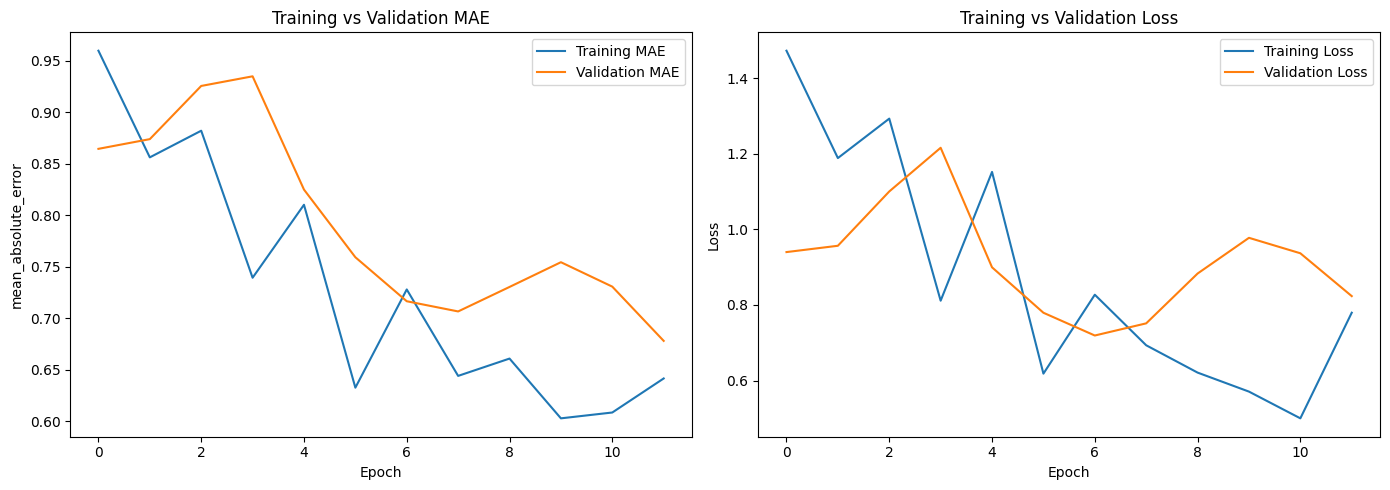

In [243]:
import matplotlib.pyplot as plt

# Assume 'history' is the object returned by your call to model.fit(...)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.title('Training vs Validation MAE')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Predicting for the match

In [60]:
teamA_players = [vitalii_zhebrakovksy, loginov_dmitrii, ivan, andrey_spiridonov, andrey_larionov, andrey_trubicin, veselin]   # player IDs for Team A
teamB_players = [sanya, roman, denys, andrey_spiridonov, andrey_selifonov, oleksandr, alex_akimov]      # player IDs for Team B
teamA_players

[15, 17, 13, 1, 3, 2, 4]

In [61]:

MAX_TEAM_SIZE = 9  # Should match model's expected size

# Pad teams to MAX_TEAM_SIZE with 0 (mask token)
def pad_team(players, max_size):
    padded = players + [0]*(max_size - len(players))
    return np.array(padded)

teamA_input = pad_team(teamA_players, MAX_TEAM_SIZE)
teamB_input = pad_team(teamB_players, MAX_TEAM_SIZE)

# Add batch dimension: shape (1, MAX_TEAM_SIZE)
teamA_input = np.expand_dims(teamA_input, axis=0)
teamB_input = np.expand_dims(teamB_input, axis=0)

# Predict using the trained model
prediction = model.predict([teamA_input, teamB_input])
print(prediction)
# If model output is sigmoid probability of Team A win:
# prob_teamA_wins = prediction[0][0]

# print(f"Predicted probability that Team A wins: {prob_teamA_wins:.3f}")

# # Optional: Decide class label
# predicted_label = 1 if prob_teamA_wins > 0.5 else 0
# print("Predicted winner:", "Team A" if predicted_label == 1 else "Team B")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[[-0.13870883]]


In [244]:

# teamA_pls = teamA_players
# print(" Team A players: ", teamA_pls)
# teamA_str = player_strengths[teamA_pls]
# print(f" Team A palyers' stregths:{teamA_str}, Total: {teamA_str.sum()}")

# teamB_pls = teamB_players
# print(" Team B players: ", teamB_pls)
# teamB_str = player_strengths[teamB_pls]
# print(f" Team B palyers' stregths:{teamB_str}, Total: {teamB_str.sum()}")
# # print(" Label (Team A wins=1):", labels[i])

In [67]:
# outcome = teamA_strength - teamB_strength
# competition_res = 1 if outcome > 0 else 0
# competition_res

## Extracting embeddings of players

In [245]:
# Direct reference to layer
player_embeddings = player_embedding.get_weights()[0]
print(player_embeddings.shape)  # (NUM_PLAYERS, PLAYER_EMB_DIM)

(31, 32)


In [246]:
print(player_embedding.input_dim)  # should show actual input_dim in the model
print(player_embedding.embeddings.shape)  

31
(31, 32)


## Try to initialize embeddings based on content based similarity.

TODO Use MPS(not sure) manifold approach to get initial embeddings

## UMAP and visualizing players in 3D

In [250]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Generate test embeddings and labels (replace these with actual data)
np.random.seed(42)
# player_embeddings = np.random.rand(32, 32)
# labels = [f'{name}' for name in team_dict.values()]
labels_points = [f'Player {idx}:{name}' for idx, name in enumerate(player_strengths)]


# Embed to 3D
reducer = umap.UMAP(n_components=3, random_state=42)
embeddings_3d = reducer.fit_transform(player_embeddings)

# Create interactive 3D scatter plot
fig = go.Figure(
    data=[go.Scatter3d(
        x=embeddings_3d[:, 0],
        y=embeddings_3d[:, 1],
        z=embeddings_3d[:, 2],
        mode='markers',
        marker=dict(
            size=7,
            color=player_strengths,       # Color by this array
            colorscale='Viridis',         # Choose a colorscale
            colorbar=dict(title='Strength'),
            opacity=0.8
        ),
        text=labels_points,          # Hover labels
        hoverinfo='text'
    )]
)

fig.update_layout(
    title="3D UMAP projection of player embeddings",
    width=1000,             # <-- Change this to your desired width in pixels
    height=800,  
    scene=dict(
        xaxis_title="UMAP-1",
        yaxis_title="UMAP-2",
        zaxis_title="UMAP-3"
    )
)

fig.show()


/opt/anaconda3/envs/footballman/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [213]:
embeddings_3d.shape

(33, 3)

## Calculate correlation of the embeddings with the original base strengths

In [248]:
import numpy as np
from scipy.stats import pearsonr

# Assuming these variables from your setup:
# player_strengths: numpy array of shape (num_players,)
# embeddings_3d: numpy array of shape (num_players, 3) -- UMAP 3D projections

num_players = player_strengths.shape[0]
correlations = []
print(player_strengths.shape)
print(embeddings_3d[:, 0].shape)
for dim in range(3):
    corr, p_value = pearsonr(embeddings_3d[:, dim], player_strengths)
    correlations.append((corr, p_value))
    print(f"Dimension {dim + 1} correlation with base strengths: r = {corr:.4f}, p-value = {p_value:.4g}")

# Optionally, compute average absolute correlation across all 3 dimensions
avg_abs_corr = np.mean([abs(c[0]) for c in correlations])
print(f"Average absolute correlation across 3 components: {avg_abs_corr:.4f}")


(31,)
(31,)
Dimension 1 correlation with base strengths: r = 0.1248, p-value = 0.5035
Dimension 2 correlation with base strengths: r = 0.4362, p-value = 0.01415
Dimension 3 correlation with base strengths: r = -0.2078, p-value = 0.2621
Average absolute correlation across 3 components: 0.2563


## Use SHAP values to explain individual contributions

In [249]:
import shap
import numpy as np

# Assume model is your trained Keras model
# Assume inputs: teamA_data, teamB_data shaped (num_samples, max_team_size)

# Concatenate team inputs if your model takes multiple inputs, or prepare tuple as needed
X = [teamA_data, teamB_data]  # example

# Choose a small background sample for SHAP (e.g., 100 samples from your train set)
background = [x[:100] for x in X]

# Initialize DeepExplainer for your keras model and background data
explainer = shap.DeepExplainer(model, background)

# Explain the model's predictions on some test samples (e.g., the first 10 games)
test_samples = [x[:10] for x in X]

# Compute SHAP values
shap_values = explainer.shap_values(test_samples)

# shap_values is a list of arrays corresponding to output shape, for a binary output usually one array
# Shape of shap_values[0] should match input shape (e.g. (10, max_team_size))

# Example: Summing contributions per player slot for team A and B separately
teamA_shap = shap_values[0] if isinstance(shap_values, list) else shap_values
teamB_shap = shap_values[1] if len(shap_values) > 1 else None  # if separate outputs per input

# Print SHAP values for first game players in team A
print("SHAP values for Team A players in game 1:", teamA_shap[0])

# You can visualize or aggregate these values to rank players by contribution


/opt/anaconda3/envs/footballman/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



TypeError: 'NoneType' object cannot be interpreted as an integer